# Industrial Meter Reader
This notebook shows how to create a industrial meter reader with OpenVINO Runtime. We use the pre-trained [PPYOLOv2](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4/configs/ppyolo) PaddlePaddle model and [DeepLabV3P](https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.5/configs/deeplabv3p) to build up a multiple inference task pipeline:

1. Run detection model to find the meters, and crop them from the origin photo.
2. Run segmentation model on these cropped meters to get the pointer and scale instance.
3. Find the location of the pointer in scale map.

![workflow](https://user-images.githubusercontent.com/91237924/166137115-67284fa5-f703-4468-98f4-c43d2c584763.png)


#### Table of content:
- [Import](#Import-Uparrow)
- [Prepare the Model and Test Image](#Prepare-the-Model-and-Test-Image-Uparrow)
- [Configuration](#Configuration-Uparrow)
- [Load the Models](#Load-the-Models-Uparrow)
- [Data Process](#Data-Process-Uparrow)
- [Main Function](#Main-Function-Uparrow)
    - [Initialize the model and parameters.](#Initialize-the-model-and-parameters.-Uparrow)
    - [Run meter detection model](#Run-meter-detection-model-Uparrow)
    - [Run meter segmentation model](#Run-meter-segmentation-model-Uparrow)
    - [Postprocess the models result and calculate the final readings](#Postprocess-the-models-result-and-calculate-the-final-readings-Uparrow)
    - [Get the reading result on the meter picture](#Get-the-reading-result-on-the-meter-picture-Uparrow)


## Import [$\Uparrow$](#Table-of-content:)


In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import math
import cv2
import tarfile
import matplotlib.pyplot as plt
import openvino as ov

sys.path.append("../utils")
from notebook_utils import download_file, segmentation_map_to_image

## Prepare the Model and Test Image [$\Uparrow$](#Table-of-content:)
Download PPYOLOv2 and DeepLabV3P pre-trained models from PaddlePaddle community.

In [2]:
MODEL_DIR = "model"
DATA_DIR = "data"
DET_MODEL_LINK = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/meter-reader/meter_det_model.tar.gz"
SEG_MODEL_LINK = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/meter-reader/meter_seg_model.tar.gz"
DET_FILE_NAME = DET_MODEL_LINK.split("/")[-1]
SEG_FILE_NAME = SEG_MODEL_LINK.split("/")[-1]
IMG_LINK = "https://user-images.githubusercontent.com/91237924/170696219-f68699c6-1e82-46bf-aaed-8e2fc3fa5f7b.jpg"
IMG_FILE_NAME = IMG_LINK.split("/")[-1]
IMG_PATH = Path(f"{DATA_DIR}/{IMG_FILE_NAME}")

os.makedirs(MODEL_DIR, exist_ok=True)

download_file(DET_MODEL_LINK, directory=MODEL_DIR, show_progress=True)
file = tarfile.open(f"model/{DET_FILE_NAME}")
res = file.extractall("model")
if not res:
    print(f"Detection Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the Detection model. Please check the network.")

download_file(SEG_MODEL_LINK, directory=MODEL_DIR, show_progress=True)
file = tarfile.open(f"model/{SEG_FILE_NAME}")
res = file.extractall("model")
if not res:
    print(f"Segmentation Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the Segmentation model. Please check the network.")

download_file(IMG_LINK, directory=DATA_DIR, show_progress=True)
if IMG_PATH.is_file():
    print(f"Test Image Saved to \"./{DATA_DIR}\".")
else:
    print("Error Downloading the Test Image. Please check the network.")

model/meter_det_model.tar.gz:   0%|          | 0.00/192M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Detection Model Extracted to "./model".


model/meter_seg_model.tar.gz:   0%|          | 0.00/94.9M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Segmentation Model Extracted to "./model".


data/170696219-f68699c6-1e82-46bf-aaed-8e2fc3fa5f7b.jpg:   0%|          | 0.00/183k [00:00<?, ?B/s]

Test Image Saved to "./data".


## Configuration [$\Uparrow$](#Table-of-content:)
Add parameter configuration for reading calculation.

In [3]:
METER_SHAPE = [512, 512] 
CIRCLE_CENTER = [256, 256] 
CIRCLE_RADIUS = 250
PI = math.pi
RECTANGLE_HEIGHT = 120
RECTANGLE_WIDTH = 1570
TYPE_THRESHOLD = 40
COLORMAP = np.array([[28, 28, 28], [238, 44, 44], [250, 250, 250]])

# There are 2 types of meters in test image datasets
METER_CONFIG = [{
    'scale_interval_value': 25.0 / 50.0,
    'range': 25.0,
    'unit': "(MPa)"
}, {
    'scale_interval_value': 1.6 / 32.0,
    'range': 1.6,
    'unit': "(MPa)"
}]

SEG_LABEL = {'background': 0, 'pointer': 1, 'scale': 2}

## Load the Models [$\Uparrow$](#Table-of-content:)
Define a common class for model loading and inference

In [4]:
# Initialize OpenVINO Runtime
core = ov.Core()


class Model:
    """
    This class represents a OpenVINO model object.

    """
    def __init__(self, model_path, new_shape, device="CPU"):
        """
        Initialize the model object
        
        Param: 
            model_path (string): path of inference model
            new_shape (dict): new shape of model input

        """
        self.model = core.read_model(model=model_path)
        self.model.reshape(new_shape)
        self.compiled_model = core.compile_model(model=self.model, device_name=device)
        self.output_layer = self.compiled_model.output(0)

    def predict(self, input_image):
        """
        Run inference
        
        Param: 
            input_image (np.array): input data
            
        Retuns:
            result (np.array)): model output data
        """
        result = self.compiled_model(input_image)[self.output_layer]
        return result

## Data Process [$\Uparrow$](#Table-of-content:)
Including the preprocessing and postprocessing tasks of each model.

In [5]:
def det_preprocess(input_image, target_size):
    """
    Preprocessing the input data for detection task

    Param: 
        input_image (np.array): input data
        size (int): the image size required by model input layer
    Retuns:
        img.astype (np.array): preprocessed image
    
    """
    img = cv2.resize(input_image, (target_size, target_size))
    img = np.transpose(img, [2, 0, 1]) / 255
    img = np.expand_dims(img, 0)
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)


def filter_bboxes(det_results, score_threshold):
    """
    Filter out the detection results with low confidence

    Param：
        det_results (list[dict]): detection results
        score_threshold (float)： confidence threshold

    Retuns：
        filtered_results (list[dict]): filter detection results
    
    """
    filtered_results = []
    for i in range(len(det_results)):
        if det_results[i, 1] > score_threshold:
            filtered_results.append(det_results[i])
    return filtered_results


def roi_crop(image, results, scale_x, scale_y):
    """
    Crop the area of detected meter of original image

    Param：
        img (np.array)：original image。
        det_results (list[dict]): detection results
        scale_x (float): the scale value in x axis
        scale_y (float): the scale value in y axis

    Retuns：
        roi_imgs (list[np.array]): the list of meter images
        loc (list[int]): the list of meter locations
    
    """
    roi_imgs = []
    loc = []
    for result in results:
        bbox = result[2:]
        xmin, ymin, xmax, ymax = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
        sub_img = image[ymin:(ymax + 1), xmin:(xmax + 1), :]
        roi_imgs.append(sub_img)
        loc.append([xmin, ymin, xmax, ymax])
    return roi_imgs, loc


def roi_process(input_images, target_size, interp=cv2.INTER_LINEAR):
    """
    Prepare the roi image of detection results data
    Preprocessing the input data for segmentation task

    Param：
        input_images (list[np.array])：the list of meter images
        target_size (list|tuple)： height and width of resized image， e.g [heigh,width]
        interp (int)：the interp method for image reszing

    Retuns：
        img_list (list[np.array])：the list of processed images
        resize_img (list[np.array]): for visualization
    
    """
    img_list = list()
    resize_list = list()
    for img in input_images:
        img_shape = img.shape
        scale_x = float(target_size[1]) / float(img_shape[1])
        scale_y = float(target_size[0]) / float(img_shape[0])
        resize_img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=interp)
        resize_list.append(resize_img)
        resize_img = resize_img.transpose(2, 0, 1) / 255
        img_mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        img_std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        resize_img -= img_mean
        resize_img /= img_std
        img_list.append(resize_img)
    return img_list, resize_list


def erode(seg_results, erode_kernel):
    """
    Erode the segmentation result to get the more clear instance of pointer and scale

    Param：
        seg_results (list[dict])：segmentation results
        erode_kernel (int): size of erode_kernel

    Return：
        eroded_results (list[dict])： the lab map of eroded_results
        
    """
    kernel = np.ones((erode_kernel, erode_kernel), np.uint8)
    eroded_results = seg_results
    for i in range(len(seg_results)):
        eroded_results[i] = cv2.erode(seg_results[i].astype(np.uint8), kernel)
    return eroded_results


def circle_to_rectangle(seg_results):
    """
    Switch the shape of label_map from circle to rectangle

    Param：
        seg_results (list[dict])：segmentation results

    Return：
        rectangle_meters (list[np.array])：the rectangle of label map

    """
    rectangle_meters = list()
    for i, seg_result in enumerate(seg_results):
        label_map = seg_result

        # The size of rectangle_meter is determined by RECTANGLE_HEIGHT and RECTANGLE_WIDTH
        rectangle_meter = np.zeros((RECTANGLE_HEIGHT, RECTANGLE_WIDTH), dtype=np.uint8)
        for row in range(RECTANGLE_HEIGHT):
            for col in range(RECTANGLE_WIDTH):
                theta = PI * 2 * (col + 1) / RECTANGLE_WIDTH
                
                # The radius of meter circle will be mapped to the height of rectangle image
                rho = CIRCLE_RADIUS - row - 1
                y = int(CIRCLE_CENTER[0] + rho * math.cos(theta) + 0.5)
                x = int(CIRCLE_CENTER[1] - rho * math.sin(theta) + 0.5)
                rectangle_meter[row, col] = label_map[y, x]
        rectangle_meters.append(rectangle_meter)
    return rectangle_meters


def rectangle_to_line(rectangle_meters):
    """
    Switch the dimension of rectangle label map from 2D to 1D

    Param：
        rectangle_meters (list[np.array])：2D rectangle OF label_map。

    Return：
        line_scales (list[np.array])： the list of scales value
        line_pointers (list[np.array])：the list of pointers value

    """
    line_scales = list()
    line_pointers = list()
    for rectangle_meter in rectangle_meters:
        height, width = rectangle_meter.shape[0:2]
        line_scale = np.zeros((width), dtype=np.uint8)
        line_pointer = np.zeros((width), dtype=np.uint8)
        for col in range(width):
            for row in range(height):
                if rectangle_meter[row, col] == SEG_LABEL['pointer']:
                    line_pointer[col] += 1
                elif rectangle_meter[row, col] == SEG_LABEL['scale']:
                    line_scale[col] += 1
        line_scales.append(line_scale)
        line_pointers.append(line_pointer)
    return line_scales, line_pointers


def mean_binarization(data_list):
    """
    Binarize the data

    Param：
        data_list (list[np.array])：input data

    Return：
        binaried_data_list (list[np.array])：output data。

    """
    batch_size = len(data_list)
    binaried_data_list = data_list
    for i in range(batch_size):
        mean_data = np.mean(data_list[i])
        width = data_list[i].shape[0]
        for col in range(width):
            if data_list[i][col] < mean_data:
                binaried_data_list[i][col] = 0
            else:
                binaried_data_list[i][col] = 1
    return binaried_data_list


def locate_scale(line_scales):
    """
    Find location of center of each scale

    Param：
        line_scales (list[np.array])：the list of binaried scales value

    Return：
        scale_locations (list[list])：location of each scale

    """
    batch_size = len(line_scales)
    scale_locations = list()
    for i in range(batch_size):
        line_scale = line_scales[i]
        width = line_scale.shape[0]
        find_start = False
        one_scale_start = 0
        one_scale_end = 0
        locations = list()
        for j in range(width - 1):
            if line_scale[j] > 0 and line_scale[j + 1] > 0:
                if not find_start:
                    one_scale_start = j
                    find_start = True
            if find_start:
                if line_scale[j] == 0 and line_scale[j + 1] == 0:
                    one_scale_end = j - 1
                    one_scale_location = (one_scale_start + one_scale_end) / 2
                    locations.append(one_scale_location)
                    one_scale_start = 0
                    one_scale_end = 0
                    find_start = False
        scale_locations.append(locations)
    return scale_locations


def locate_pointer(line_pointers):
    """
    Find location of center of pointer

    Param：
        line_scales (list[np.array])：the list of binaried pointer value

    Return：
        scale_locations (list[list])：location of pointer

    """
    batch_size = len(line_pointers)
    pointer_locations = list()
    for i in range(batch_size):
        line_pointer = line_pointers[i]
        find_start = False
        pointer_start = 0
        pointer_end = 0
        location = 0
        width = line_pointer.shape[0]
        for j in range(width - 1):
            if line_pointer[j] > 0 and line_pointer[j + 1] > 0:
                if not find_start:
                    pointer_start = j
                    find_start = True
            if find_start:
                if line_pointer[j] == 0 and line_pointer[j + 1] == 0 :
                    pointer_end = j - 1
                    location = (pointer_start + pointer_end) / 2
                    find_start = False
                    break
        pointer_locations.append(location)
    return pointer_locations


def get_relative_location(scale_locations, pointer_locations):
    """
    Match location of pointer and scales

    Param：
        scale_locations (list[list])：location of each scale
        pointer_locations (list[list])：location of pointer

    Return：
        pointed_scales (list[dict])： a list of dict with:
                                     'num_scales': total number of scales
                                     'pointed_scale': predicted number of scales
            
    """
    pointed_scales = list()
    for scale_location, pointer_location in zip(scale_locations,
                                                pointer_locations):
        num_scales = len(scale_location)
        pointed_scale = -1
        if num_scales > 0:
            for i in range(num_scales - 1):
                if scale_location[i] <= pointer_location < scale_location[i + 1]:
                    pointed_scale = i + (pointer_location - scale_location[i]) / (scale_location[i + 1] - scale_location[i] + 1e-05) + 1
        result = {'num_scales': num_scales, 'pointed_scale': pointed_scale}
        pointed_scales.append(result)
    return pointed_scales


def calculate_reading(pointed_scales):
    """
    Calculate the value of meter according to the type of meter

    Param：
        pointed_scales (list[list])：predicted number of scales

    Return：
        readings (list[float])： the list of values read from meter
            
    """
    readings = list()
    batch_size = len(pointed_scales)
    for i in range(batch_size):
        pointed_scale = pointed_scales[i]
        # find the type of meter according the total number of scales
        if pointed_scale['num_scales'] > TYPE_THRESHOLD:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[0]['scale_interval_value']
        else:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[1]['scale_interval_value']
        readings.append(reading)
    return readings

## Main Function [$\Uparrow$](#Table-of-content:)


### Initialize the model and parameters. [$\Uparrow$](#Table-of-content:)


select device from dropdown list for running inference using OpenVINO

In [6]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

The number of detected meter from detection network can be arbitrary in some scenarios, which means the batch size of segmentation network input is a [dynamic dimension](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_DynamicShapes.html), and it should be specified as ```-1``` or the ```ov::Dimension()``` instead of a positive number used for static dimensions. In this case, for memory consumption optimization, we can specify the lower and/or upper bounds of input batch size.

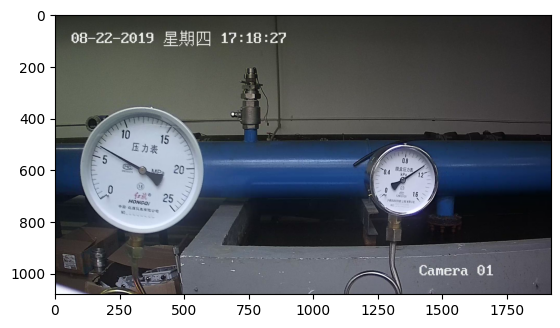

In [7]:
img_file = f"{DATA_DIR}/{IMG_FILE_NAME}"
det_model_path = f"{MODEL_DIR}/meter_det_model/model.pdmodel"
det_model_shape = {'image': [1, 3, 608, 608], 'im_shape': [1, 2], 'scale_factor': [1, 2]}
seg_model_path = f"{MODEL_DIR}/meter_seg_model/model.pdmodel"
seg_model_shape = {'image': [ov.Dimension(1, 2), 3, 512, 512]}

erode_kernel = 4
score_threshold = 0.5
seg_batch_size = 2
input_shape = 608

# Intialize the model objects
detector = Model(det_model_path, det_model_shape, device.value)
segmenter = Model(seg_model_path, seg_model_shape, device.value)

# Visulize a original input photo
image = cv2.imread(img_file)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

### Run meter detection model [$\Uparrow$](#Table-of-content:)
Detect the location of the meter and prepare the ROI images for segmentation.

The detection result image has been saved as "detection_results.jpg" in data


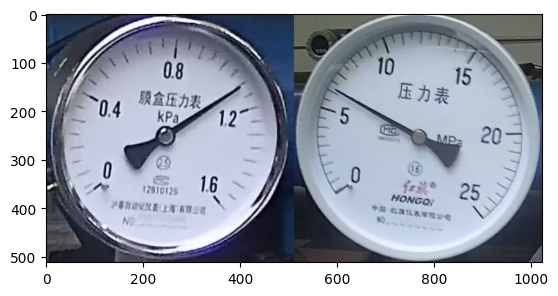

In [8]:
# Prepare the input data for meter detection model
im_shape = np.array([[input_shape, input_shape]]).astype('float32')
scale_factor = np.array([[1, 2]]).astype('float32')
input_image = det_preprocess(image, input_shape)
inputs_dict = {'image': input_image, "im_shape": im_shape, "scale_factor": scale_factor}

# Run meter detection model
det_results = detector.predict(inputs_dict)

# Filter out the bounding box with low confidence
filtered_results = filter_bboxes(det_results, score_threshold)

# Prepare the input data for meter segmentation model
scale_x = image.shape[1] / input_shape * 2
scale_y = image.shape[0] / input_shape

# Create the individual picture for each detected meter
roi_imgs, loc = roi_crop(image, filtered_results, scale_x, scale_y)
roi_imgs, resize_imgs = roi_process(roi_imgs, METER_SHAPE)

# Create the pictures of detection results
roi_stack = np.hstack(resize_imgs)

if cv2.imwrite(f"{DATA_DIR}/detection_results.jpg", roi_stack):
    print("The detection result image has been saved as \"detection_results.jpg\" in data")
    plt.imshow(cv2.cvtColor(roi_stack, cv2.COLOR_BGR2RGB))

### Run meter segmentation model [$\Uparrow$](#Table-of-content:)
Get the results of segmentation task on detected ROI.

The segmentation result image has been saved as "segmentation_results.jpg" in data


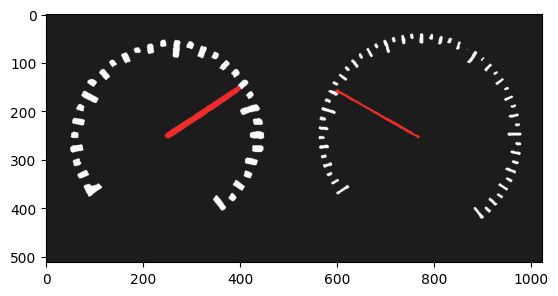

In [9]:
seg_results = list()
mask_list = list()
num_imgs = len(roi_imgs)

# Run meter segmentation model on all detected meters
for i in range(0, num_imgs, seg_batch_size):
    batch = roi_imgs[i : min(num_imgs, i + seg_batch_size)]
    seg_result = segmenter.predict({"image": np.array(batch)})
    seg_results.extend(seg_result)
results = []
for i in range(len(seg_results)):
    results.append(np.argmax(seg_results[i], axis=0)) 
seg_results = erode(results, erode_kernel)

# Create the pictures of segmentation results
for i in range(len(seg_results)):
    mask_list.append(segmentation_map_to_image(seg_results[i], COLORMAP))
mask_stack = np.hstack(mask_list)

if cv2.imwrite(f"{DATA_DIR}/segmentation_results.jpg", cv2.cvtColor(mask_stack, cv2.COLOR_RGB2BGR)):
    print("The segmentation result image has been saved as \"segmentation_results.jpg\" in data")
    plt.imshow(mask_stack)

### Postprocess the models result and calculate the final readings [$\Uparrow$](#Table-of-content:)
Use OpenCV function to find the location of the pointer in a scale map.

The rectangle_meters result image has been saved as "rectangle_meters.jpg" in data


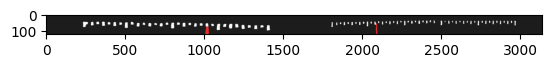

In [10]:
# Find the pointer location in scale map and calculate the meters reading 
rectangle_meters = circle_to_rectangle(seg_results)
line_scales, line_pointers = rectangle_to_line(rectangle_meters)
binaried_scales = mean_binarization(line_scales)
binaried_pointers = mean_binarization(line_pointers)
scale_locations = locate_scale(binaried_scales)
pointer_locations = locate_pointer(binaried_pointers)
pointed_scales = get_relative_location(scale_locations, pointer_locations)
meter_readings = calculate_reading(pointed_scales)

rectangle_list = list()
# Plot the rectangle meters
for i in range(len(rectangle_meters)):
    rectangle_list.append(segmentation_map_to_image(rectangle_meters[i], COLORMAP))
rectangle_meters_stack = np.hstack(rectangle_list)

if cv2.imwrite(f"{DATA_DIR}/rectangle_meters.jpg", cv2.cvtColor(rectangle_meters_stack, cv2.COLOR_RGB2BGR)):
    print("The rectangle_meters result image has been saved as \"rectangle_meters.jpg\" in data")
    plt.imshow(rectangle_meters_stack)

### Get the reading result on the meter picture [$\Uparrow$](#Table-of-content:)


Meter 1: 1.100
Meter 2: 6.185
The reading results image has been saved as "reading_results.jpg" in data


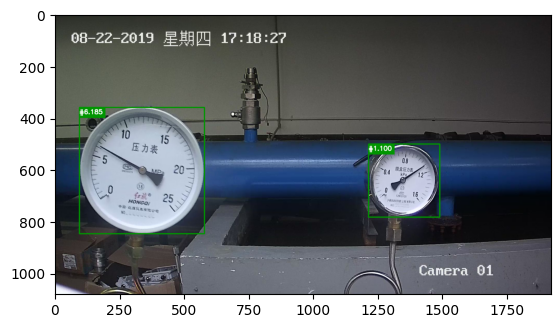

In [11]:
# Create a final result photo with reading
for i in range(len(meter_readings)):
    print("Meter {}: {:.3f}".format(i + 1, meter_readings[i]))
    
result_image = image.copy()
for i in range(len(loc)):
    cv2.rectangle(result_image,(loc[i][0], loc[i][1]), (loc[i][2], loc[i][3]), (0, 150, 0), 3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(result_image, (loc[i][0], loc[i][1]), (loc[i][0] + 100, loc[i][1] + 40), (0, 150, 0), -1)
    cv2.putText(result_image, "#{:.3f}".format(meter_readings[i]), (loc[i][0],loc[i][1] + 25), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
if cv2.imwrite(f"{DATA_DIR}/reading_results.jpg", result_image):
    print("The reading results image has been saved as \"reading_results.jpg\" in data")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

## Try it with your meter photos!